In [1]:
import tensorflow as tf
import zipfile
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib
from pydub import AudioSegment

DATA_DIR = pathlib.Path('data')
TEST_DIR = pathlib.Path('data/test')


In [2]:

# def notebook_extract(): 
#     import ipynb.fs.defs.audio_extraction as audio_extraction
#     audio_extraction.extract_zip(TEST_DIR, DATA_DIR)
#     print('-' * 50)
#     print('-' * 50)  
#     audio_extraction.rename_audio_files(DATA_DIR)

# notebook_extract()

In [3]:
# Funktion zum Extrahieren eines Chunks aus der Mitte
def get_middle_chunk(file_path, chunk_length_seconds):
    audio = AudioSegment.from_file(file_path)
    chunk_length_ms = chunk_length_seconds * 1000  # Konvertiere Sekunden in Millisekunden
    total_length_ms = len(audio)
    
    if total_length_ms <= chunk_length_ms:
        # Wenn die Datei kürzer ist als der gewünschte Abschnitt, gebe die gesamte Datei zurück
        return audio
    
    # Berechne den Startpunkt für den mittleren Chunk
    start_point = (total_length_ms - chunk_length_ms) // 2
    return audio[start_point:start_point + chunk_length_ms]

In [ ]:
def run(zip_file_path = "saved_models/very_good_model.zip", seconds = None):
    # zip_file_path = "saved_models/very_good_model.zip"
    # zip_file_path = "saved_model/first_good_ model.zip"
    zip_file_path = "saved_models/model_loss_0.449_acc_0.906_val_loss_0.191_val_acc_0.963.zip"
    
    # Entpacke das Modell
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall("restored_model")
    print(f"Used Model: {zip_file_path}")    
    
    
    loaded_model = tf.saved_model.load("restored_model")
    audio_dir = "data/test"
    results = []
    print(f"Split test files in {seconds}") if seconds else print("Use complete files")

    for audio_file in os.listdir(audio_dir):
        audio_file_path = os.path.join(audio_dir, audio_file)
        
        if audio_file.endswith(".wav"):
            if(seconds):
                chunk = get_middle_chunk(audio_file_path, seconds)
        
                temp_chunk_path = "restored_model/temp_chunk.wav"
                chunk.export(temp_chunk_path, format="wav")
            
                result = loaded_model(tf.constant(temp_chunk_path))
            else:
                result = loaded_model(tf.constant(audio_file_path))

            # Extrahiere Vorhersagedaten und formatiere sie auf 4 Nachkommastellen als String
            predictions = result['predictions'].numpy()[0]
            class_names = ["original", "upscale-from-mp3-128"]
            class_probabilities = {class_names[i]: f"{predictions[i]:.4f}" for i in range(len(predictions))}

            results.append({
                "Dateiname": audio_file,
                **class_probabilities  
            })

    os.remove(temp_chunk_path) if seconds else None
            
    # Erstelle einen DataFrame aus den Ergebnissen
    df = pd.DataFrame(results)

    # Ausgabe der Tabelle
    # print(df)
    
    # Optional: Tabelle grafisch anzeigen
    fig, ax = plt.subplots(figsize=(16, len(df) * 0.4))  # Breitere Tabelle für längere Dateinamen
    ax.axis('tight')
    ax.axis('off')

    # Formatieren der Zellen als Strings mit 4 Dezimalstellen
    cell_text = [[f"{value:.4f}" if isinstance(value, float) else value for value in row] for row in df.values]

    # Erstelle die Tabelle in matplotlib
    table = ax.table(cellText=cell_text, colLabels=df.columns, cellLoc="center", loc="center", colWidths=[0.5, 0.25, 0.25])

    # Tabelle verschönern: Farben hinzufügen
    for (i, j), cell in table.get_celld().items():
        if i == 0:  # Titelzeile
            cell.set_fontsize(12)
            cell.set_text_props(weight='bold')
            cell.set_facecolor('#d3d3d3')  # Heller Hintergrund für die Titelzeile
        else:  # Zelleninhalt
            if j == 0:  # Dateiname-Spalte
                cell.set_facecolor('#f0f8ff')  # Blauer Hintergrund für die Dateinamen
            else:
                # Setze die Farben der Wahrscheinlichkeiten
                if float(cell.get_text().get_text()) < 0.5:
                    cell.set_facecolor('#f8d7da')  # Rot, wenn Wahrscheinlichkeit < 0.5
                else:
                    cell.set_facecolor('#d4edda')  # Grün, wenn Wahrscheinlichkeit >= 0.5
            cell.set_fontsize(10)

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)  # Skaliere die Tabelle für bessere Lesbarkeit
    plt.show()

# Test Model

Used Model: saved_models/model_loss_0.449_acc_0.906_val_loss_0.191_val_acc_0.963.zip
Use complete files


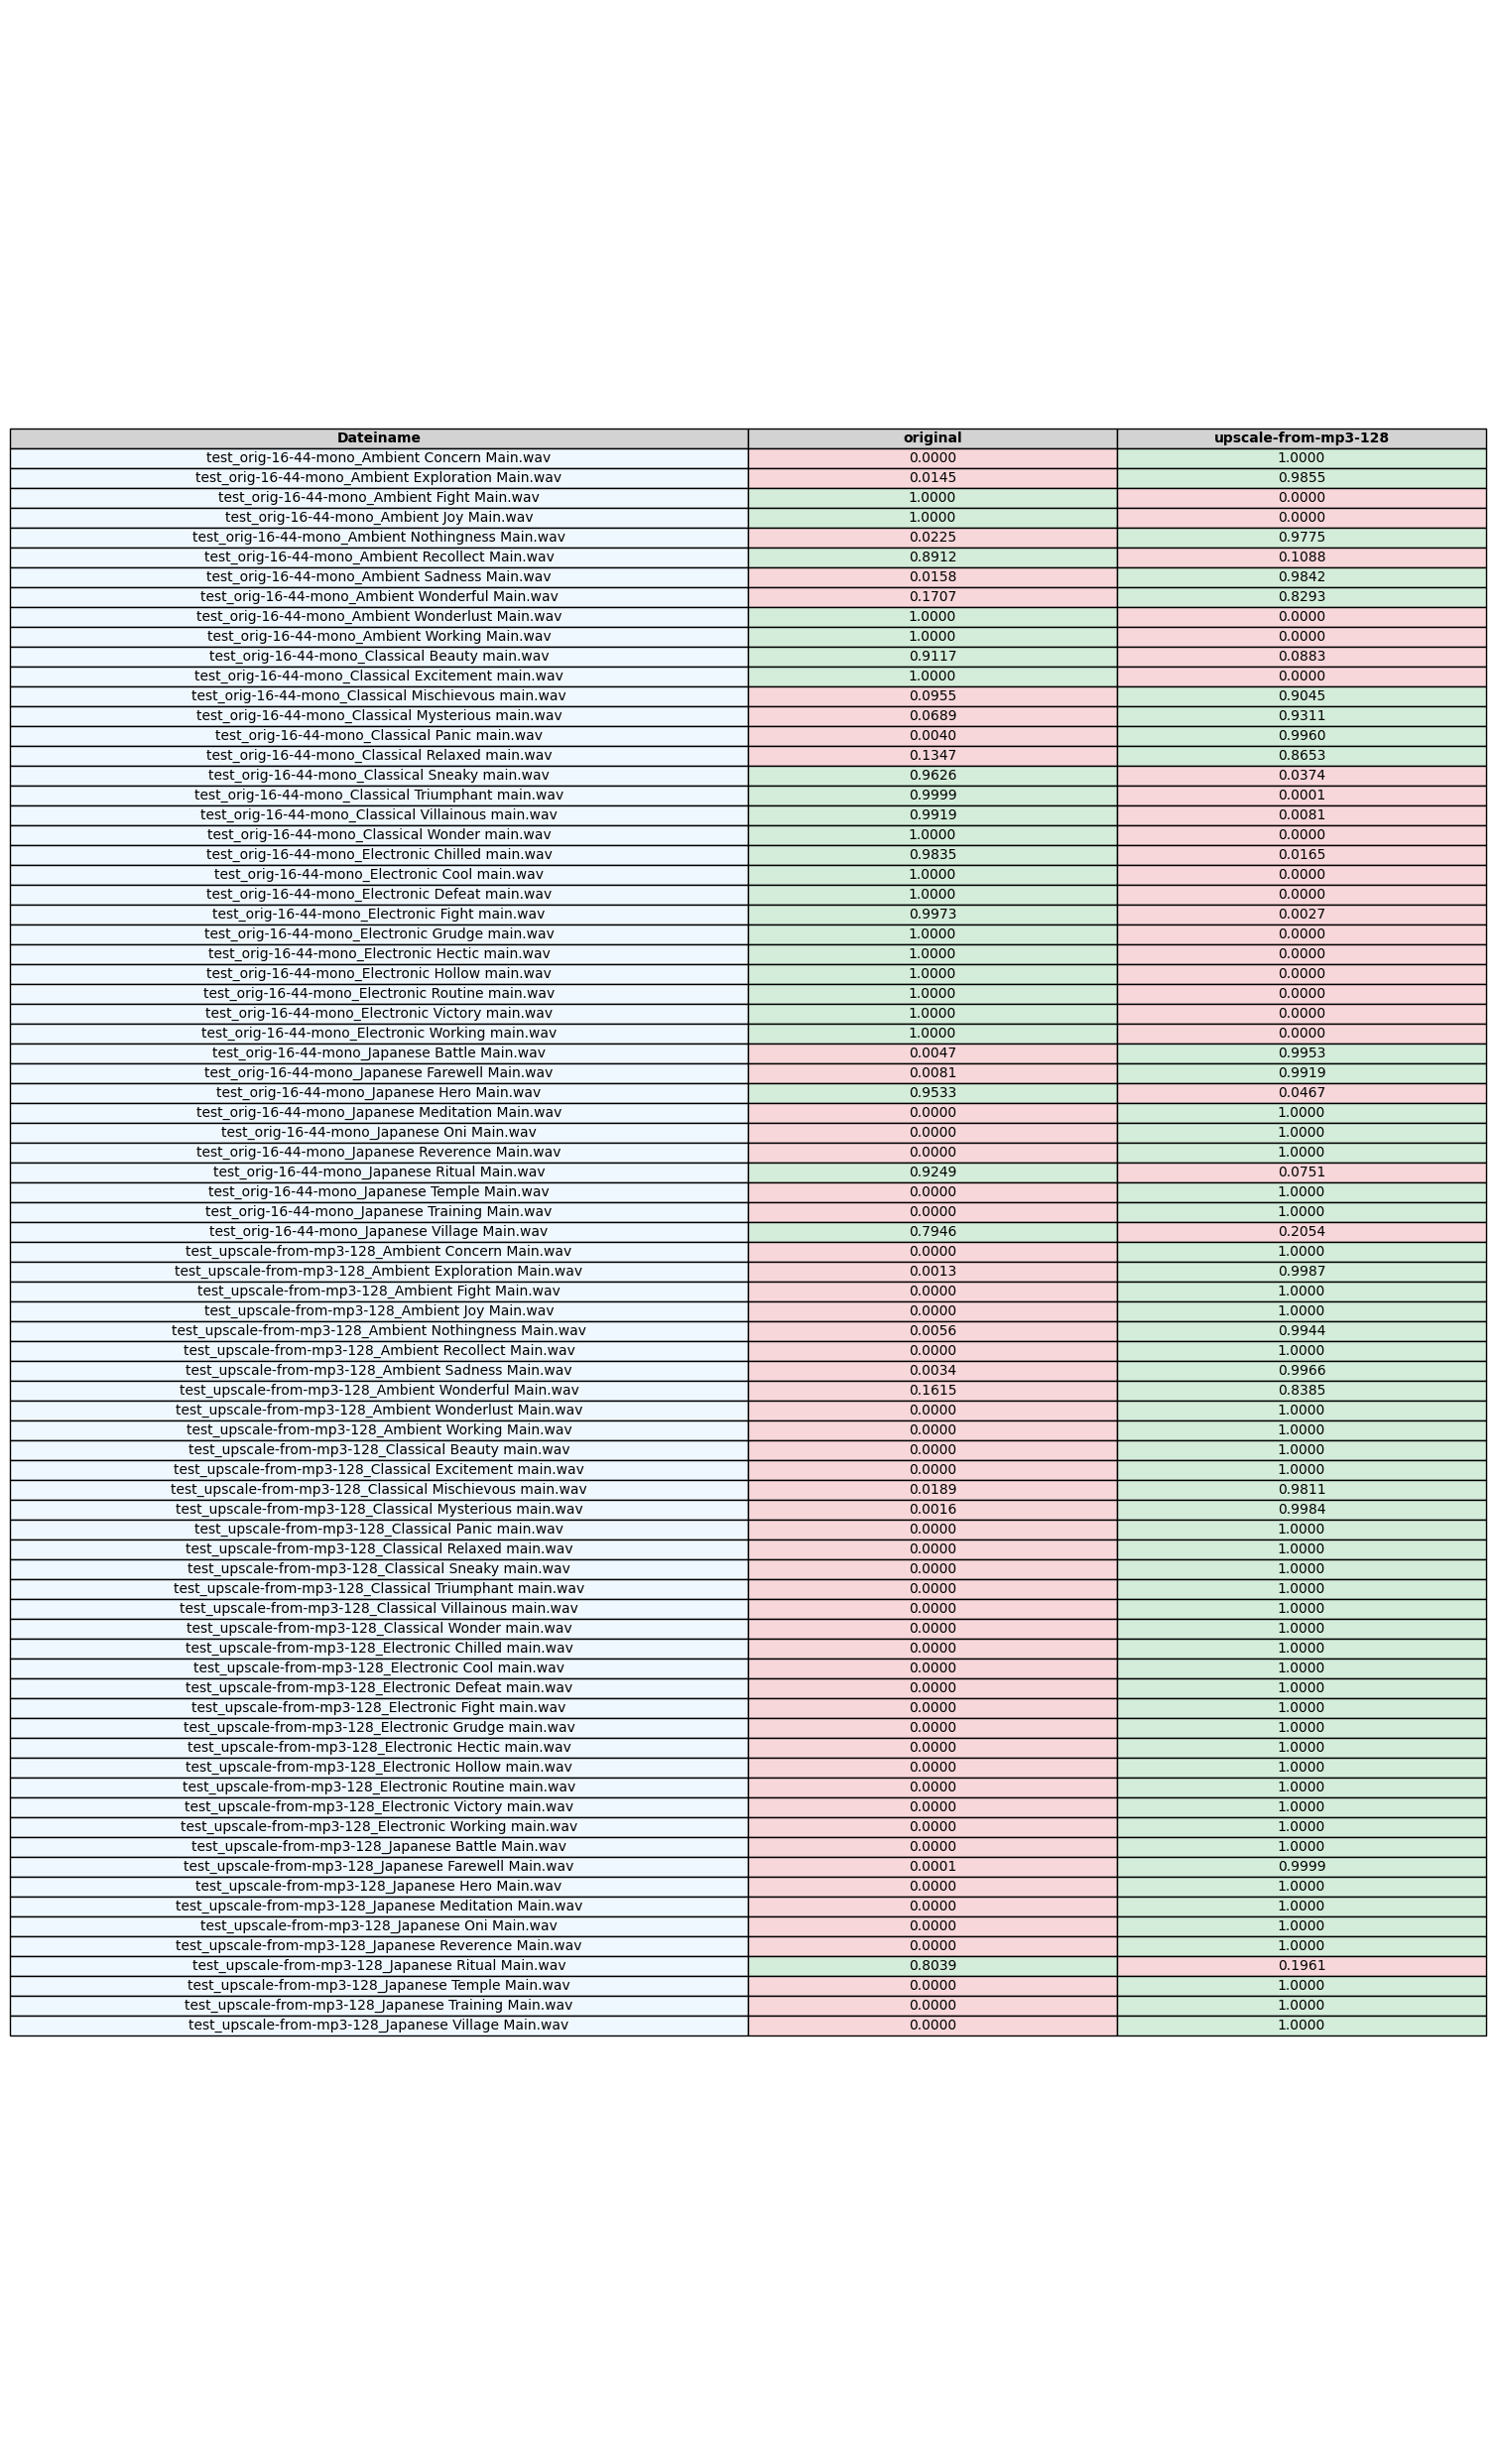

In [5]:
run()